This iPython Notebook walks through the process of injesting cyclical multivariate timeseries data of varying samples per variable, extracting a truncated feature set from the data with [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), then training an MLP classification algorithm on the freatures and provided labels. This is all done explicity with Numpy and TensorFlow, although librarys exist which handle large parts of this process automatically. 

begin by loading the data into numpy arrays

In [1]:
import numpy as np
ps1 = np.loadtxt("./data/PS1.txt")
ps2 = np.loadtxt("./data/PS2.txt")
ps3 = np.loadtxt("./data/PS3.txt")
ps4 = np.loadtxt("./data/PS4.txt")
ps5 = np.loadtxt("./data/PS5.txt")
ps6 = np.loadtxt("./data/PS6.txt")
eps1 = np.loadtxt("./data/EPS1.txt")
fs1 = np.loadtxt("./data/FS1.txt")
fs2 = np.loadtxt("./data/FS2.txt")
ts1 = np.loadtxt("./data/TS1.txt")
ts2 = np.loadtxt("./data/TS2.txt")
ts3 = np.loadtxt("./data/TS3.txt")
ts4 = np.loadtxt("./data/TS4.txt")
vs1 = np.loadtxt("./data/VS1.txt")
ce = np.loadtxt("./data/CE.txt")
cp = np.loadtxt("./data/CP.txt")
se = np.loadtxt("./data/SE.txt")

data_list = [ps1, ps2, ps3, ps4, ps5, ps6, eps1, fs1, fs2, ts1, ts2, ts3, ts4, vs1, ce, cp, se]

verify the data was loaded correctly by printing the shape and plotting the first row of each array

(2205, 6000)


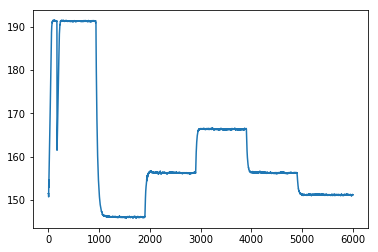

(2205, 6000)


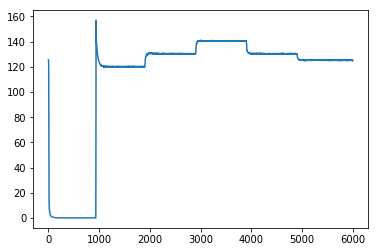

(2205, 6000)


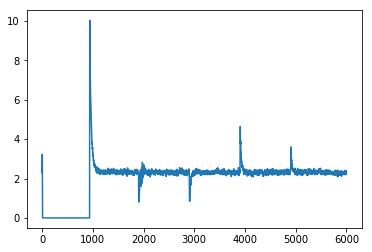

(2205, 6000)


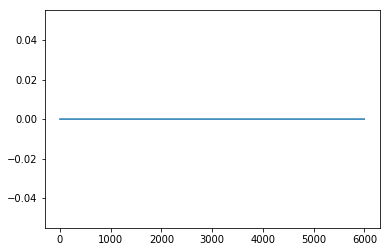

(2205, 6000)


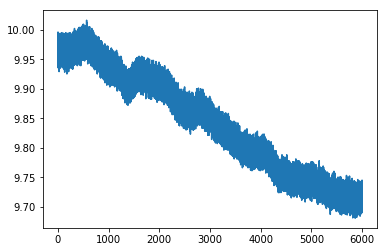

(2205, 6000)


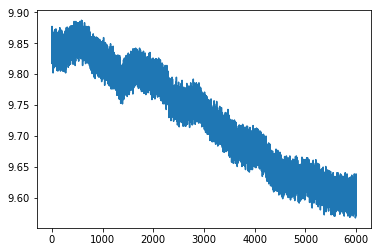

(2205, 6000)


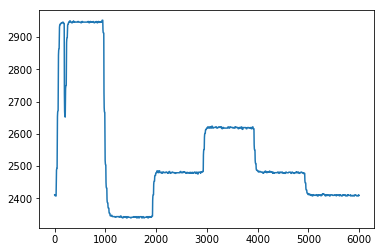

(2205, 600)


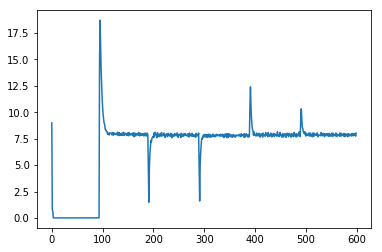

(2205, 600)


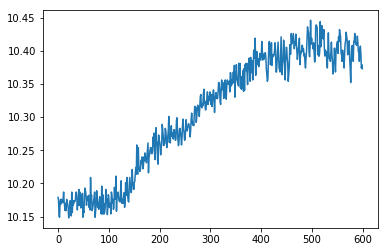

(2205, 60)


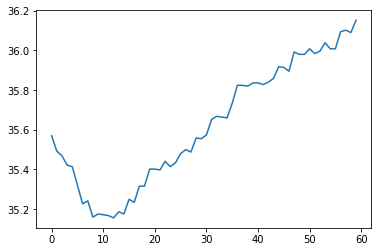

(2205, 60)


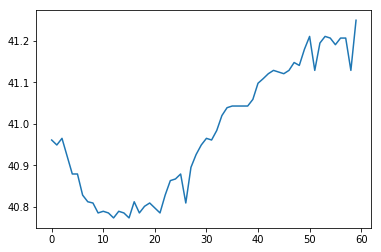

(2205, 60)


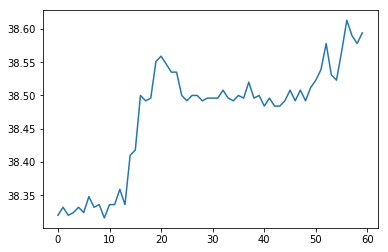

(2205, 60)


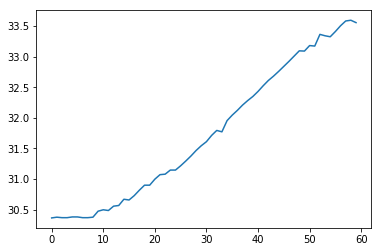

(2205, 60)


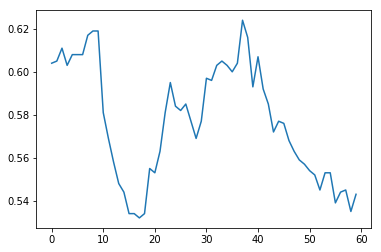

(2205, 60)


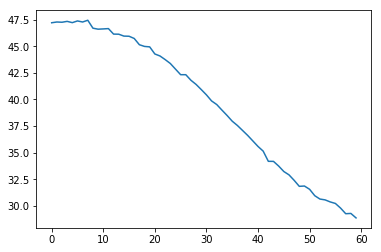

(2205, 60)


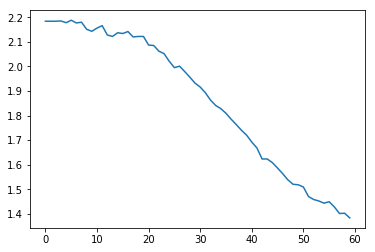

(2205, 60)


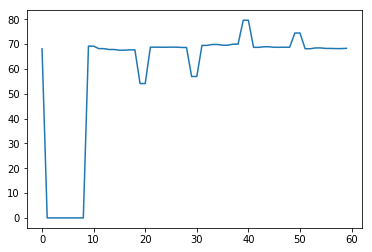

In [3]:
import matplotlib.pyplot as plt
for array in data_list:
    print(array.shape)
    plt.plot(array[0])
    plt.show()

we want to produce a set of basis functions, $\psi_k$, for each of the datasets which will allow us to reduce its dimensionality while still adequately representing the full data. First we need to obtain zero-meaned datasets to apply EOFs. Compute the mean vector for each set:

In [4]:
mean_v_list= [np.mean(array, axis=0, dtype=np.float64) for array in data_list]

View the average vector from each set

(6000,)


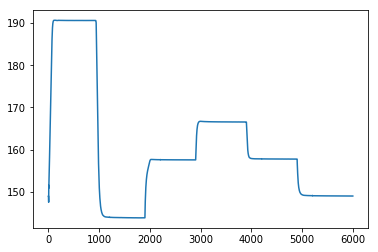

(6000,)


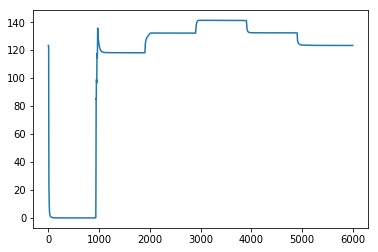

(6000,)


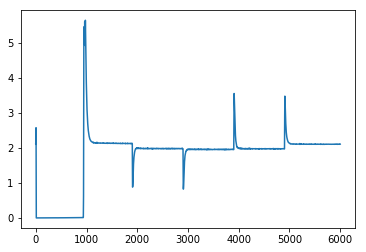

(6000,)


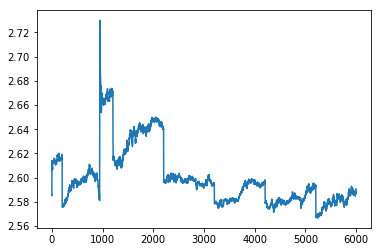

(6000,)


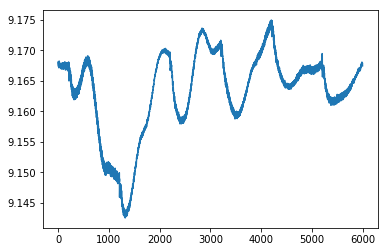

(6000,)


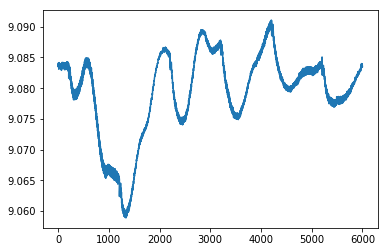

(6000,)


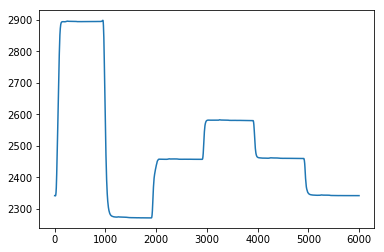

(600,)


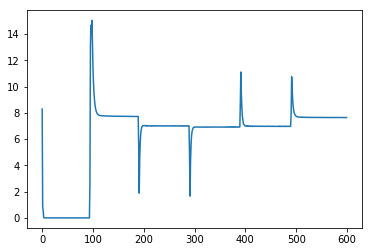

(600,)


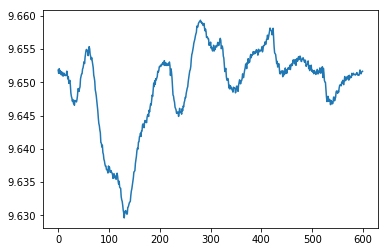

(60,)


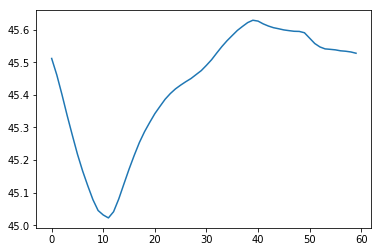

(60,)


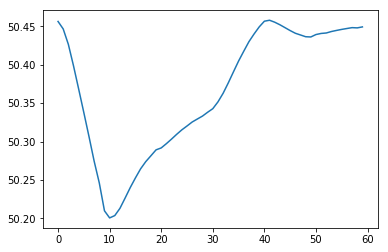

(60,)


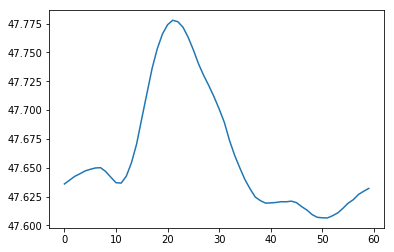

(60,)


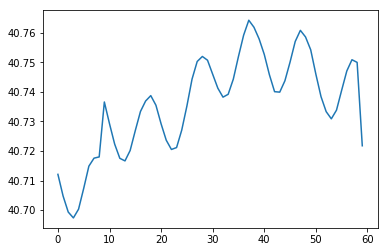

(60,)


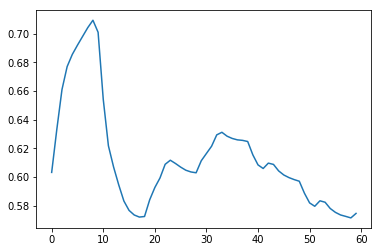

(60,)


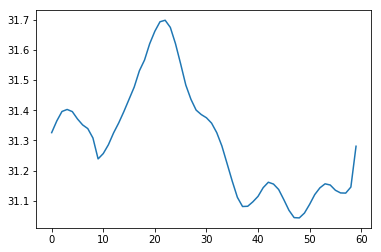

(60,)


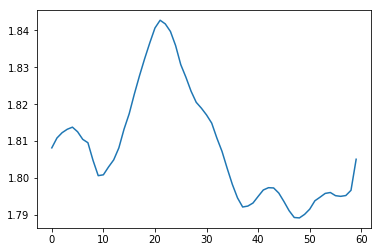

(60,)


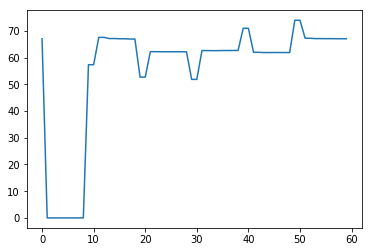

In [5]:
for array in mean_v_list:
    print(array.shape)
    plt.plot(array)
    plt.show()

subtract each dataset by its mean vector to obtain a zero-meaned dataset for each. We can add the means back in later to reconstuct the vectors generated by our new basis set

In [6]:
zero_meaned_list = [data_list[i]-mean_v_list[i] for i in range(len(data_list))]

(2205, 6000)


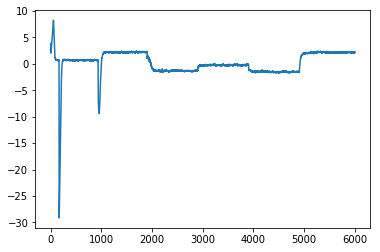

(2205, 6000)


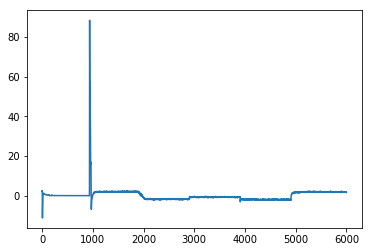

(2205, 6000)


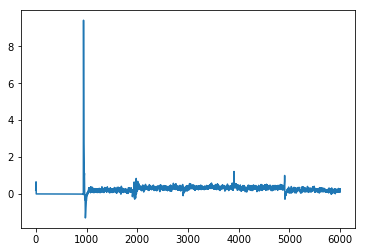

(2205, 6000)


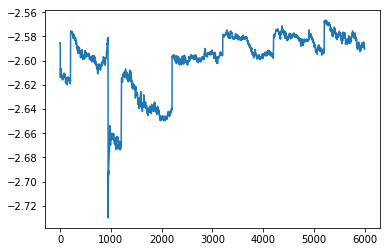

(2205, 6000)


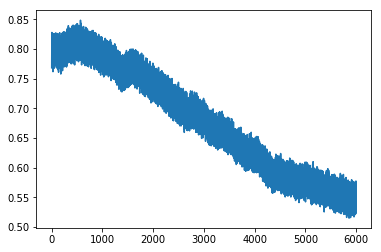

(2205, 6000)


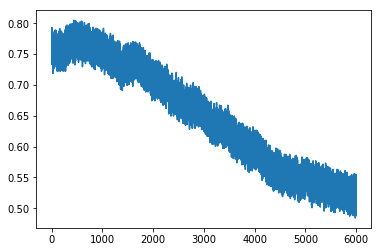

(2205, 6000)


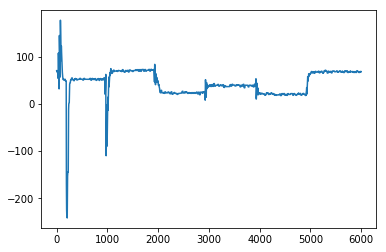

(2205, 600)


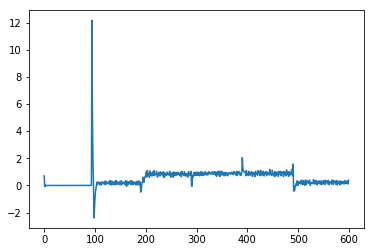

(2205, 600)


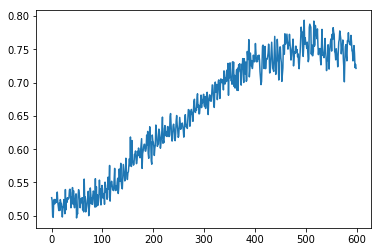

(2205, 60)


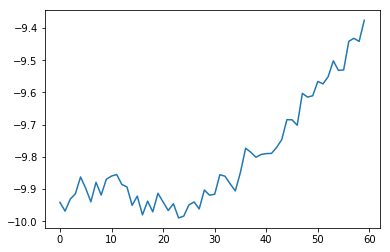

(2205, 60)


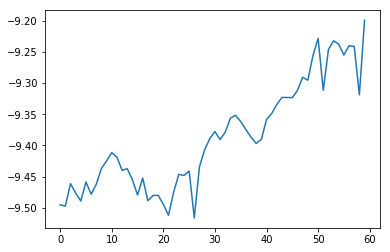

(2205, 60)


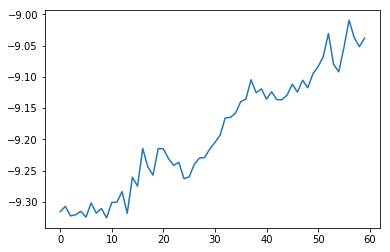

(2205, 60)


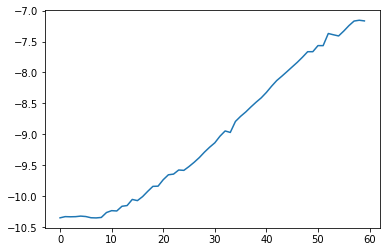

(2205, 60)


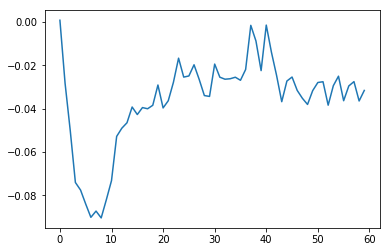

(2205, 60)


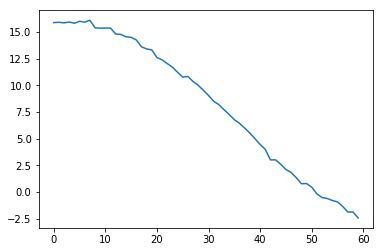

(2205, 60)


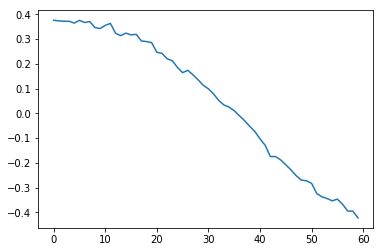

(2205, 60)


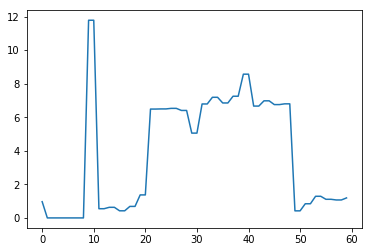

In [7]:
for array in zero_meaned_list:
    print(array.shape)
    plt.plot(array[0])
    plt.show()

now compute the covariance matrix for each set

In [8]:
cov_list = [np.cov(array, rowvar=False) for array in zero_meaned_list]

Now to find the eigenvectors of $C$ and their eigenvalues. The eigenvectors will form our basis and the eigenvalues will represent the "weight" its corresponding eigenvector has in the dataset.

In [9]:
eig_vec_list = []
eig_val_list = []
for i in range(len(data_list)):
    w, v = np.linalg.eig(cov_list[i])
    eig_vec_list.append(v.real)
    eig_val_list.append(w.real)

# we dont need the covariance matrices anymore
del cov_list[:]
del cov_list

Now to sort the arrays of eigenvalues and vectors so that they are in order of descending eigenvalue. Note that the eigenvectors exist column-wise in the vector matrices.

In [10]:
indices_list = [np.argsort(eig_vals) for eig_vals in eig_val_list]

for i, indices in enumerate(indices_list):
    eig_val_list[i] = eig_val_list[i][indices[::-1]]
    eig_vec_list[i] = eig_vec_list[i][:,indices[::-1]]

plot the ordered eigenvalues for each of the data

(6000,)


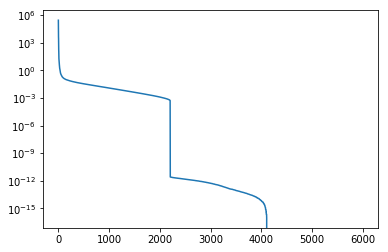

(6000,)


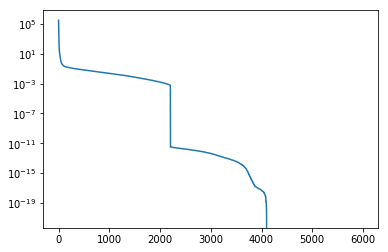

(6000,)


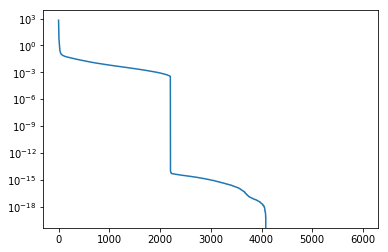

(6000,)


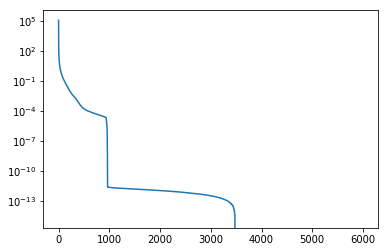

(6000,)


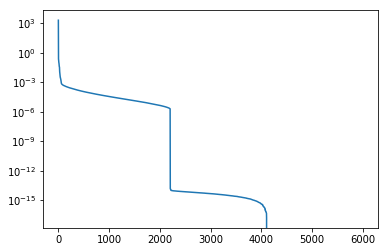

(6000,)


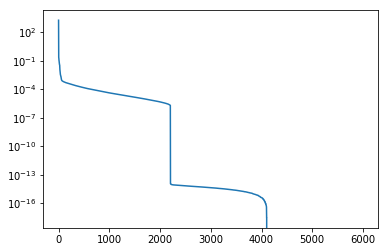

(6000,)


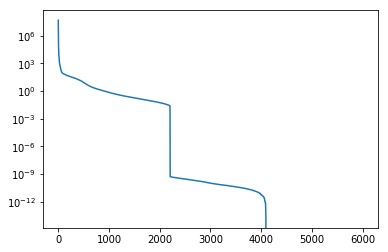

(600,)


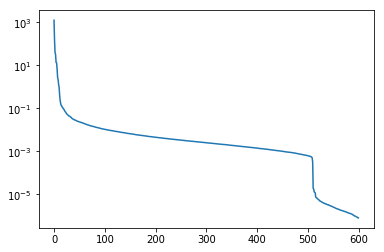

(600,)


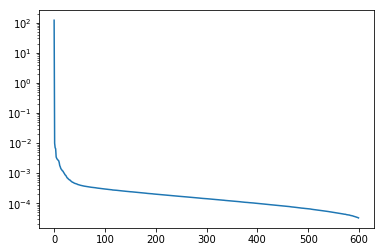

(60,)


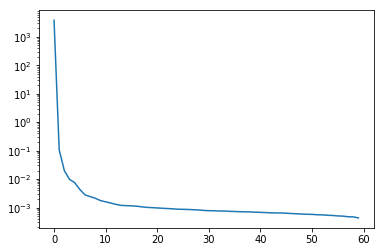

(60,)


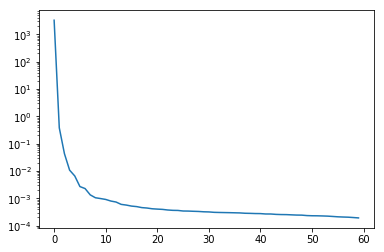

(60,)


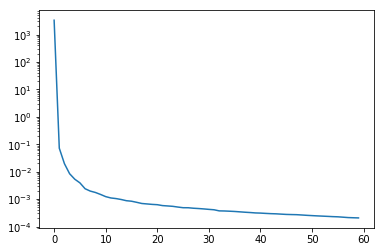

(60,)


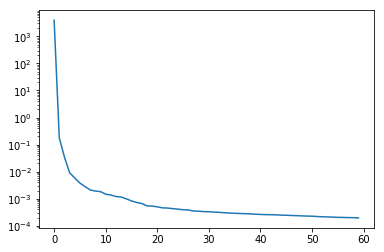

(60,)


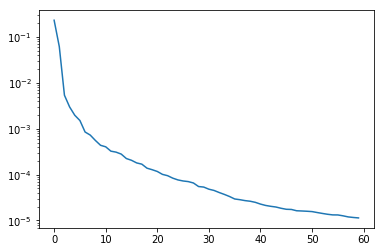

(60,)


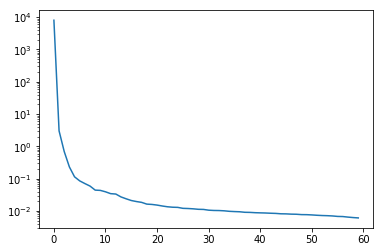

(60,)


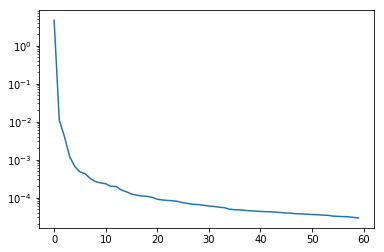

(60,)


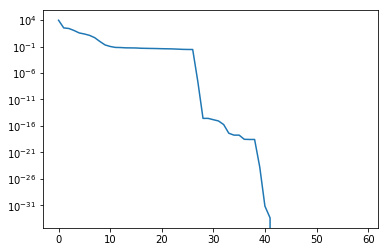

In [11]:
for array in eig_val_list:
    print(array.shape)
    plt.semilogy(array)
    plt.show()

In [12]:
indices_list = [np.argsort(eig_vals) for eig_vals in eig_val_list]

plot the first eigenvector for each of the data. It should capture some patterns of the corresponding zero-meaned dataset

(6000, 6000)


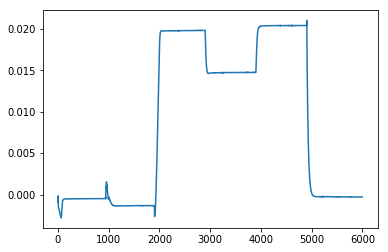

(6000, 6000)


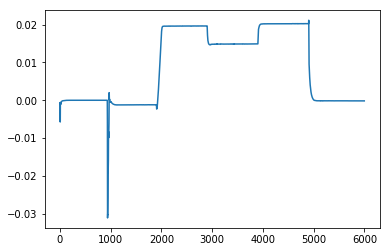

(6000, 6000)


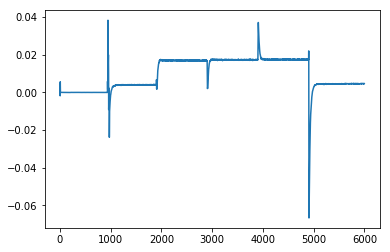

(6000, 6000)


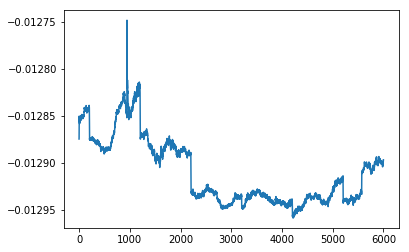

(6000, 6000)


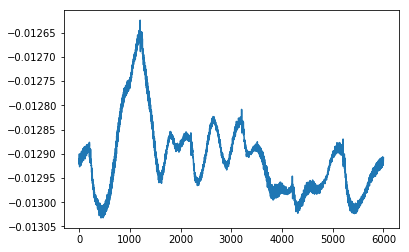

(6000, 6000)


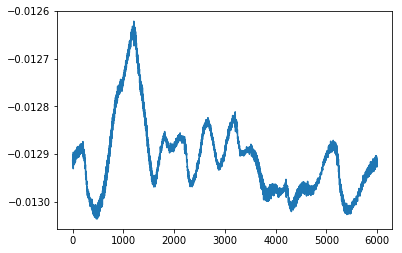

(6000, 6000)


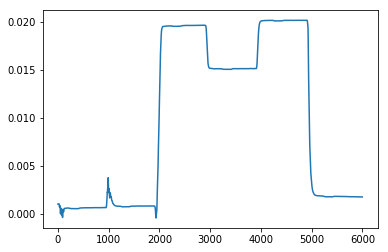

(600, 600)


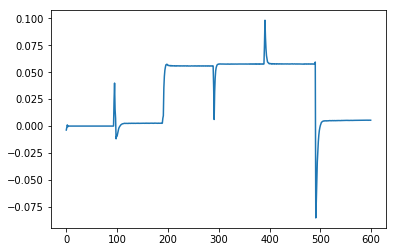

(600, 600)


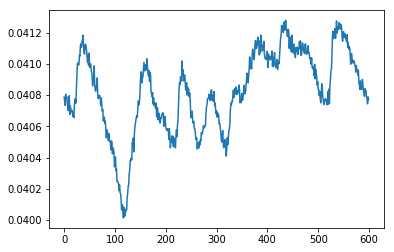

(60, 60)


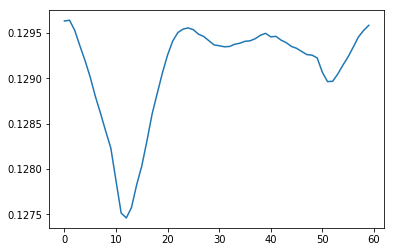

(60, 60)


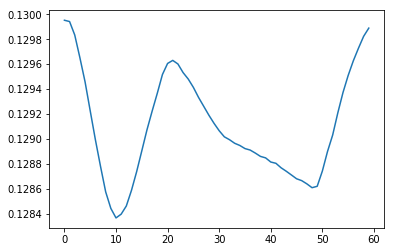

(60, 60)


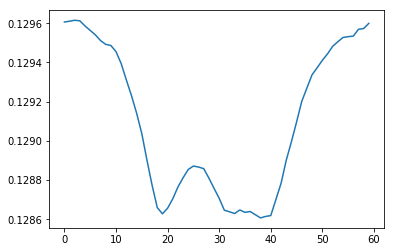

(60, 60)


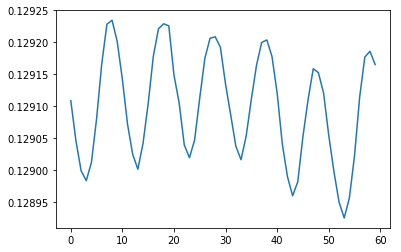

(60, 60)


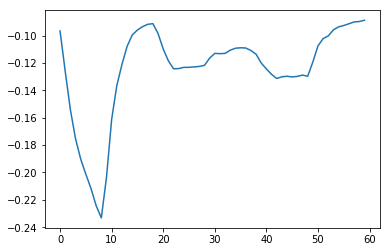

(60, 60)


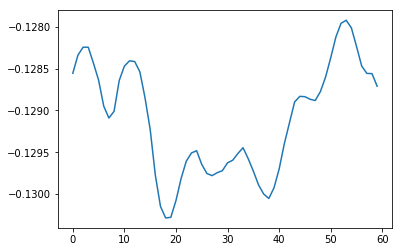

(60, 60)


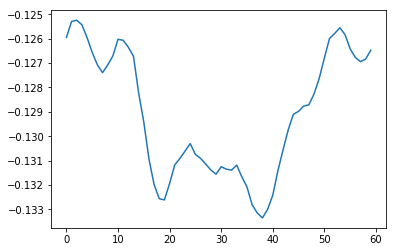

(60, 60)


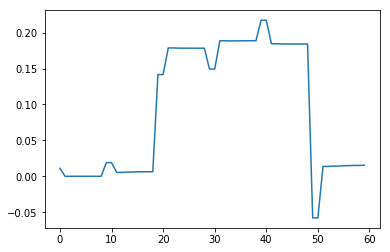

In [13]:
for array in eig_vec_list:
    print(array.shape)
    plt.plot(array[:,0])
    plt.show()

Now we need a transformation that maps any feature vector to a vector of coordinates with respect to our new basis of eigenvectors. Since our matrix of eigenvectors for a particular dataset, $V$, forms a transformation from the coordinate space spanned by the eigenvectors to the standard basis, we need only compute $V^{-1}$. Luckily, since the covariance matrix is real and symmetric, $V$ is guarenteed to be orthogonal and therefore $V^{-1}=V^T$

In [14]:
transformed_data = []
for i in range(17):
    transformed_data.append((eig_vec_list[i].T @ zero_meaned_list[i].T).T)

Now we truncate the feature size of the transformed data down to 100 (or not at all if the dataset has fewer features). This number is a tunable parameter

In [15]:

for i in range(len(transformed_data)):
    transformed_data[i] = transformed_data[i][:,:200]

We should be able to approximately reconstruct the first row from zero_meaned_list by multiplying the first row of the truncated feature space matrix (augmented to the right with zeros)  by the eigenvector matrix:

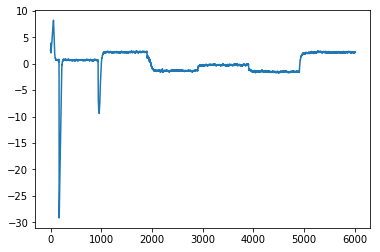

In [16]:
plt.plot(eig_vec_list[0]@(np.append(transformed_data[0][0],np.zeros(5800))).T)
plt.show()

Randomly partition a sample from the data to be a validation set. The validation set is not to be used in training

In [17]:
import random

validation_size = transformed_data[0].shape[0] // 10

train_data_indx = list(range(transformed_data[0].shape[0]))
val_data_indx = []
for _ in range(validation_size):
    val_data_indx.append(train_data_indx.pop(random.randrange(len(train_data_indx))))
    
    

Load in the label data and transform it with min/max normalization

In [18]:
label_data = np.loadtxt("./data/profile.txt")
label_mins = label_data.min(axis=0)
label_maxes = label_data.max(axis=0)

label_data = (label_data - label_mins) / (label_maxes - label_mins)

In [19]:
import tensorflow as tf
import importlib
import models
importlib.reload(models)
from models import *

Now train the network

total trainable parameters: 3390469
Epoch 500/500... Batch 490/496 ... Training Loss: 0.1483... Validation Loss: 0.1949
Finished training! Training Loss: 0.14832518994808197... Validation Loss: 0.19489304721355438


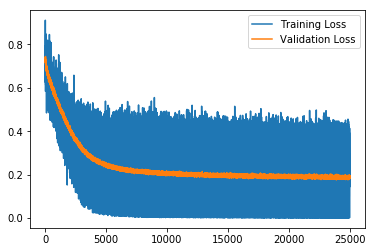

In [20]:
feature_size = sum([array.shape[1] for array in transformed_data])
label_size = label_data.shape[1]
learning_rate = 1e-6
epoch_count = 500
batch_size = 4
out_dim = label_data.shape[1]

train_graph = tf.Graph()
with train_graph.as_default():
    # initialize tf variables
    inputs, labels, lr = mlp_inputs(feature_size, label_size)
    logits, predictions = mlp(inputs, label_size)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    model_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    batch_i = 0
    train_loss_data = []
    val_loss_data = []
    train_loss = None
    val_loss = None
    
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())
        print("total trainable parameters:", 
              np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))

        for epoch_i in range(epoch_count):
            batch_i = 0
            while (batch_i + 1) * batch_size <= len(train_data_indx):
                # extract a batch from the training data and labels
                indx_start = batch_i*batch_size
                indx_end = (batch_i+1)*batch_size
                feature_batch = [array[train_data_indx][indx_start:indx_end] for array in transformed_data]
                # the feature batch is passed through np.tanh() to normalize
                feature_batch = np.tanh(np.concatenate(feature_batch, axis=1))
                labels_batch = label_data[train_data_indx][indx_start:indx_end]

                # run model optimizer on the batch
                _ = sess.run(model_opt, feed_dict={inputs:feature_batch, labels:labels_batch})

                if batch_i % 10 == 0:
                    # compute and record the training loss
                    train_loss = loss.eval({inputs:feature_batch, labels:labels_batch})
                    train_loss_data.append(train_loss)

                    # compute and record the validation loss
                    val_features = [array[val_data_indx][:] for array in transformed_data]
                    val_features = np.tanh(np.concatenate(val_features, axis=1))
                    val_loss = loss.eval({inputs:val_features, labels:label_data[val_data_indx]})
                    val_loss_data.append(val_loss)

                    # print training losses
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{} ...".format(batch_i, len(train_data_indx)//batch_size),
                          "Training Loss: {:.4f}...".format(train_loss),
                          "Validation Loss: {:.4f}".format(val_loss),
                          end="\r",)                    
                batch_i += 1

        print("\nFinished training!",
              "Training Loss: {}...".format(train_loss),
              "Validation Loss: {}".format(val_loss))
        train, = plt.plot(train_loss_data, label="Training Loss")
        val, = plt.plot(val_loss_data, label="Validation Loss")
        plt.legend(handles=[train, val])
        plt.show()
        
        saver = tf.train.Saver()
        saver.save(sess, './pca-mlp/')

        

In [21]:
with train_graph.as_default():
    inputs, labels, lr = mlp_inputs(feature_size, label_size)
    _, predictions = mlp(inputs, label_size, is_train=False)
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, './pca-mlp/')
        
        val_features = [array[val_data_indx][:] for array in transformed_data]
        val_features = np.tanh(np.concatenate(val_features, axis=1)) 
        y_ = sess.run(predictions, {inputs:val_features})
        y = label_data[val_data_indx][:]
        #print(y)
        print("mean absolute error: ", np.mean(np.abs(y_-y)))

INFO:tensorflow:Restoring parameters from ./PCA-MLP/
mean absolute error:  0.03834145009298501


Since the labels are normalized, we can infer the network's validation accuracy to be 96.17%